<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Convolutions/conv_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython import display

In [2]:
!pip install wandb

display.clear_output()

In [3]:
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import wandb

from matplotlib import pyplot as plt
from torchvision import transforms, datasets
from tqdm import tqdm_notebook

In [4]:
%matplotlib inline

In [5]:
cifar_means = (0.49139968, 0.48215827, 0.44653124)
cifar_stds = (0.24703233, 0.24348505, 0.26158768)

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_means, cifar_stds)])

In [7]:
BATCH_TRAIN = 4
BATCH_TEST = 4
WRKRS = 2
TOWHERE = './data'
SEED = 42
EPOCHS = 5
LR = 1e-4

In [74]:
WNB_FLAG = False
API_KEY = ''
WNB_PROJECT = 'custom_CIFAR10'
WNB_LOGIN = 'dimildizio'

In [9]:
def log_wnb(model, conf):
  if WNB_FLAG:
    os.environ["WANDB_API_KEY"] = API_KEY
    wandb.init(project=WNB_PROJECT, entity=WNB_LOGIN, reinit=True, config=conf)
    wandb.watch(model, log='all')

def log_step(name, iloss, accuracy):
  if WNB_FLAG:
      wandb.log({name+'_loss':iloss,
          name+'_accuracy': accuracy})


In [10]:
trainset = datasets.CIFAR10(root = TOWHERE, train=True, download=True, transform = transform)
testset = datasets.CIFAR10(root = TOWHERE, train=False, download=True, transform = transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_TRAIN, num_workers = WRKRS, pin_memory = True, shuffle = True)
test_loader = torch.utils.data.DataLoader(testset, batch_size = BATCH_TEST, num_workers = WRKRS, pin_memory = True, shuffle = False)

100%|██████████| 170498071/170498071 [00:03<00:00, 46646213.71it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [12]:
print('Train:', train_loader.dataset.data.shape)
print('Test:', test_loader.dataset.data.shape)

Train: (50000, 32, 32, 3)
Test: (10000, 32, 32, 3)


In [13]:
def seed_all(seed):
  random.seed(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEDD'] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.determetistic = True
  torch.backends.cudnn.benchmark = False

seed_all(SEED)

In [14]:
def getnum():
  return np.random.randint(low=0, high=10000)

In [15]:
class MyCIFAR(nn.Module):
  def __init__(self):
    super(MyCIFAR, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)
    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)


  def convolute(self, conv, x):
    convd = conv(x)
    activated = F.relu(convd)
    pooled = self.pool(activated)
    return pooled

  def fcs(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return x


  def forward(self, x):
    x = self.convolute(self.conv1, x)
    x = self.convolute(self.conv2, x)
    x = self.flatten(x)
    x = self.fcs(x)
    return x


In [15]:
def getloss(netparam, y_pred, y, loss_fn, logitnorm = False):
  if logitnorm:
    y_pred = F.softmax(y_pred, dim=1)
    loss = loss_fn(y_pred, y)
    l2reg = torch.tensor(0.)
    for p in netparam:
      l2reg += torch.norm(p,p=2)
    loss += 0.001*l2reg
  else:
    loss = loss_fn(y_pred, y)
  return loss

In [25]:
def get_device():
  cuda = 'cuda' if torch.cuda.is_available() else 'cpu'
  return torch.device(cuda)


In [28]:
def train(net, optimizer, loss_fn, normalize=False, epochs=EPOCHS, scheduler=False):
  net.train()
  device = get_device()
  net.to(device)

  for epoch in range(epochs):
    curloss = 0.0
    correct=0
    total_samples = 0

    for i, batch in enumerate(tqdm_notebook(train_loader)):
      optimizer.zero_grad()
      X, y = batch
      X = X.to(device)
      y = y.to(device)
      y_pred = net(X)

      pred = y_pred.argmax(dim=1, keepdim=True)
      correct += pred.eq(y.view_as(pred)).sum().item()
      total_samples += y.size(0)

      loss = getloss(net.parameters(), y_pred, y, loss_fn, normalize)
      loss.backward()
      optimizer.step()
      curloss += loss.item()

      if not (i % int(train_loader.dataset.data.shape[0] / BATCH_TRAIN / 10)):
        print(f'Epoch: {epoch+1}, loss: {round(curloss, 3)}')
        curloss = 0.0
    log_step('train', loss, correct / total_samples)
    if scheduler:
      scheduler.step()    #should possibly be after optimizer for the sake of the first iteration

In [27]:
def eval_me(net):
  net.eval()
  device = get_device()
  net.to(device)
  iloss = nn.CrossEntropyLoss()
  class_correct = [0]*10
  class_total = [0]*10
  correct=0
  total_samples = 0
  total_loss = 0.0

  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      y_pred = net(images)

      loss = iloss(y_pred, labels)
      total_loss +=loss.item()

      pred = y_pred.argmax(dim=1, keepdim=True)
      correct+= pred.eq(labels.view_as(pred)).sum().item()
      total_samples += labels.size(0)

      _, predicted = torch.max(y_pred,1)
      c = (predicted == labels).squeeze()
      for i in range(len(labels)):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1

  results = []
  for i in range(10):
    result_i = 100 * class_correct[i] / class_total[i]
    results.append(result_i)
    print(f'Accuracy: {classes[i]}: {result_i}%')

  acc =  correct / total_samples
  log_step('test', total_loss, acc)


In [18]:
def visualize_result(idx, net):
    img = test_loader.dataset.data[idx]
    plt.imshow(img)

    image = transform(img)
    y_pred = net(image.view(1, 3, 32, 32))
    _, predicted = torch.max(y_pred, 1)
    plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')


In [19]:
def get_watch(net, optimizer=optim.Adam, lr=LR, epoch = EPOCHS, scheduler=False, normalize = False):
  paramdict = {'epochs':epoch, 'train_batch':BATCH_TRAIN, 'num_workers':WRKRS,
              'lr':lr, 'seed':SEED, 'classes':10}
  net = net()
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = optimizer(net.parameters(), lr=lr)
  if scheduler:
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)

  log_wnb(net, paramdict)

  train(net, optimizer, loss_fn, epochs=epoch, scheduler=scheduler, normalize=normalize)
  eval_me(net)
  if WNB_FLAG:
    wandb.finish()
  return net

In [ ]:
get_watch(MyCIFAR, epoch=5, lr=1e-3, normalize=True, scheduler=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-59-52913d69420a>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 1, loss: 2.32
Epoch: 1, loss: 2819.463
Epoch: 1, loss: 2760.595
Epoch: 1, loss: 2754.203
Epoch: 1, loss: 2720.843
Epoch: 1, loss: 2707.169
Epoch: 1, loss: 2696.71
Epoch: 1, loss: 2698.364
Epoch: 1, loss: 2673.632
Epoch: 1, loss: 2700.639


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 2, loss: 1.566
Epoch: 2, loss: 2661.498
Epoch: 2, loss: 2665.699
Epoch: 2, loss: 2652.762
Epoch: 2, loss: 2641.695
Epoch: 2, loss: 2622.919
Epoch: 2, loss: 2620.237
Epoch: 2, loss: 2624.003
Epoch: 2, loss: 2603.706
Epoch: 2, loss: 2615.547


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 3, loss: 1.989
Epoch: 3, loss: 2585.814
Epoch: 3, loss: 2555.997
Epoch: 3, loss: 2557.978
Epoch: 3, loss: 2574.266
Epoch: 3, loss: 2553.762
Epoch: 3, loss: 2560.905
Epoch: 3, loss: 2553.0
Epoch: 3, loss: 2548.848
Epoch: 3, loss: 2545.986


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 4, loss: 1.766
Epoch: 4, loss: 2534.502
Epoch: 4, loss: 2508.613
Epoch: 4, loss: 2507.686
Epoch: 4, loss: 2515.27
Epoch: 4, loss: 2519.047
Epoch: 4, loss: 2509.324
Epoch: 4, loss: 2501.115
Epoch: 4, loss: 2493.102
Epoch: 4, loss: 2505.07


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 5, loss: 1.987
Epoch: 5, loss: 2481.606
Epoch: 5, loss: 2495.867
Epoch: 5, loss: 2484.292
Epoch: 5, loss: 2492.293
Epoch: 5, loss: 2496.655
Epoch: 5, loss: 2496.341
Epoch: 5, loss: 2496.34
Epoch: 5, loss: 2480.741
Epoch: 5, loss: 2495.524
Accuracy: plane: 51.1%
Accuracy: car: 62.5%
Accuracy: bird: 26.9%
Accuracy: cat: 35.0%
Accuracy: deer: 28.7%
Accuracy: dog: 41.9%
Accuracy: frog: 63.8%
Accuracy: horse: 56.0%
Accuracy: ship: 53.0%
Accuracy: truck: 57.4%


test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆▇█
train_loss,█▁▅▅▃
test_accuracy,0.4763
test_loss,14376.69492
train_accuracy,0.4993
train_loss,1.9911


In [ ]:
net = MyCIFAR()
train(net, optim.Adam(net.parameters(), lr=LR, weight_decay=0.001), nn.CrossEntropyLoss(), normalize=True)
eval_me(net)

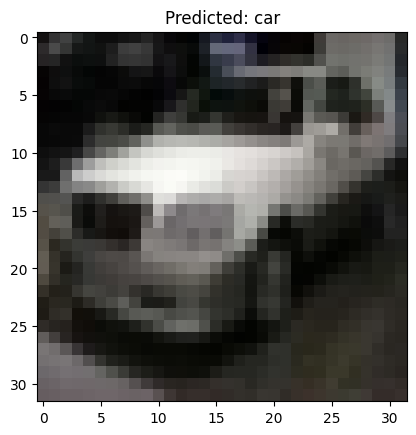

In [ ]:
visualize_result(getnum(), net)

### Conditions: baseline\custom\logitnorm

> Batchsize:4\10\10

> Start loss: ~900\1100\1150

> End loss: ~400\760\1040


>>Accuracy: plane: 51.6% \ 62.1% \ 61.4%

>>Accuracy: car: 63.7% \ 56.1%  \ 50%

>>Accuracy: bird: 34.6% \ 44.2% \ 15.7%

>>Accuracy: cat: 53.8% \ 23.4% \ 17.8%

>>Accuracy: deer: 42.4% \ 37.5% \ 31.8%

>>Accuracy: dog: 0.0% \ 45.2% \ 22.7%

>>Accuracy: frog: 74.2% \ 71.9% \ 67.5%

>>Accuracy: horse: 66.9% \61.1% \ 52.3%

>>Accuracy: ship: 69.3% \ 0.0% \ 0.0%

>>Accuracy: truck: 55.8% \ 66.5% \ 64.5%


On this particular model looks like smaller batchsize (4) works better compared to larger (10). Also we've tested Alpha's logitnorm (used to fight overfitting) but in our case it worked worse even though it had been stated that l2 regularization and normalization of y_pred before putting it into loss function won't worsen the result.

Lets count the size for inputs one more time

1. Input image has 3 channels $32*32 = 32*32*3 =3072$ so the size is 3072
2. We retain the channels and calculate output size for **Width** and **Height** for first convolutions that is $Width^{out} = \frac{32-5 + 2*0}{1}+1 =28$ and $Height^{out} = \frac{32-5 + 2*0}{1}+1 =28$
3. We specified that or **out_channels=6** and **filter=5** so we've applied **six 5x5** filters to the image and resulted in **6(channels) * 28(width) * 28(height)** output
4. Apply max pooling stride=2 kernel=2 which lowers the dimensions to **6x14x14=1176**
5. For next convolution the out_channels=16 kernel=5 so for input 14x14 we take $Width^{out}=\frac{14-5+2*0}{1}+1=10$ and $Height^{out}=\frac{14-5+2*0}{1}+1=10$
6. The output is **16x10x10**
7. We dont do the pooling here and go straight to conv3
8. Third convolution makes **out_channels=32, kernel=5 for 10x10** input we get $Width^{out}=\frac{10-5+2*0}{1}+1=6$ and $Height^{out}=\frac{10-5+2*0}{1}+1=6$
9. And the output is **32x6x6**
10. Max pooling for stride=2 filter=2 makes it **32x3x3=288**
11. We perform the flattening which makes it **(288,)**
12. And the input size on the first fully-connected layer is **288** in our case
13. **288 -> 120 -> 84 -> 10** classes on output

In [42]:
class AnotherConv(nn.Module):
  def __init__(self):
    super(AnotherConv, self).__init__()

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.flatten = nn.Flatten()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size = 5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size = 5)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size = 5)

    self.fc1 = nn.Linear(288, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)


  def forward(self, x):
    #print(x.size(0),x.size(1),x.size(2),x.size(3))
    x = self.pool(F.relu(self.conv1(x)))
    #print(x.size(0),x.size(1),x.size(2),x.size(3))
    x = self.pool(self.conv3(F.relu(self.conv2(x))))
    #print(x.size(0),x.size(1),x.size(2),x.size(3))
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
net1 = AnotherConv()
train(net1, optim.Adam(net1.parameters(), lr=1e-3), nn.CrossEntropyLoss())
eval_me(net1)

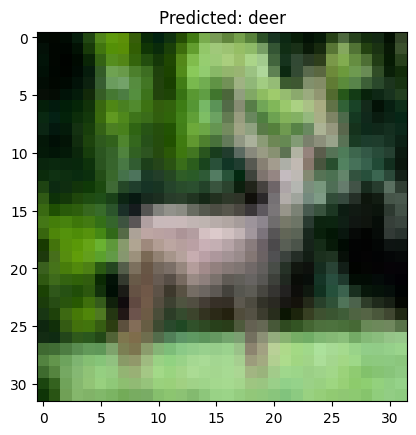

In [ ]:
visualize_result(getnum(), net1)

In [ ]:
get_watch(AnotherConv)

wandb: Currently logged in as: dimildizio. Use `wandb login --relogin` to force relogin


<ipython-input-20-f1b2d4f9d3ec>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 1, loss: 2.288
Epoch: 1, loss: 2665.05
Epoch: 1, loss: 2397.094
Epoch: 1, loss: 2322.207
Epoch: 1, loss: 2238.885
Epoch: 1, loss: 2178.665
Epoch: 1, loss: 2136.635
Epoch: 1, loss: 2081.692
Epoch: 1, loss: 2054.644
Epoch: 1, loss: 2010.059


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 2, loss: 2.154
Epoch: 2, loss: 1946.605
Epoch: 2, loss: 1926.979
Epoch: 2, loss: 1874.823
Epoch: 2, loss: 1867.327
Epoch: 2, loss: 1853.559
Epoch: 2, loss: 1864.734
Epoch: 2, loss: 1830.308
Epoch: 2, loss: 1836.434
Epoch: 2, loss: 1792.133


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 3, loss: 1.205
Epoch: 3, loss: 1738.1
Epoch: 3, loss: 1740.495
Epoch: 3, loss: 1713.25
Epoch: 3, loss: 1732.629
Epoch: 3, loss: 1712.488
Epoch: 3, loss: 1680.058
Epoch: 3, loss: 1726.702
Epoch: 3, loss: 1708.241
Epoch: 3, loss: 1660.639
Accuracy: plane: 47.2%
Accuracy: car: 52.9%
Accuracy: bird: 31.4%
Accuracy: cat: 37.0%
Accuracy: deer: 42.9%
Accuracy: dog: 54.7%
Accuracy: frog: 59.4%
Accuracy: horse: 58.0%
Accuracy: ship: 67.3%
Accuracy: truck: 65.1%


test_accuracy,▁
test_loss,▁
train_accuracy,▁▆█
train_loss,▂█▁
test_accuracy,0.5159
test_loss,3394.41108
train_accuracy,0.509
train_loss,0.83124


In [ ]:
get_watch(AnotherConv, optimizer = optim.Adagrad, lr = 1e-2, epoch=5)

<ipython-input-20-f1b2d4f9d3ec>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 1, loss: 2.294
Epoch: 1, loss: 2460.085
Epoch: 1, loss: 2107.014
Epoch: 1, loss: 1998.566
Epoch: 1, loss: 1948.608
Epoch: 1, loss: 1889.358
Epoch: 1, loss: 1816.386
Epoch: 1, loss: 1822.74
Epoch: 1, loss: 1780.584
Epoch: 1, loss: 1760.877


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 2, loss: 2.233
Epoch: 2, loss: 1718.094
Epoch: 2, loss: 1707.045
Epoch: 2, loss: 1702.552
Epoch: 2, loss: 1646.869
Epoch: 2, loss: 1653.678
Epoch: 2, loss: 1652.63
Epoch: 2, loss: 1640.807
Epoch: 2, loss: 1580.314
Epoch: 2, loss: 1608.825


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 3, loss: 1.444
Epoch: 3, loss: 1563.306
Epoch: 3, loss: 1579.371
Epoch: 3, loss: 1547.0
Epoch: 3, loss: 1516.68
Epoch: 3, loss: 1537.63
Epoch: 3, loss: 1580.485
Epoch: 3, loss: 1561.958
Epoch: 3, loss: 1537.695
Epoch: 3, loss: 1506.893


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.711
Epoch: 4, loss: 1473.747
Epoch: 4, loss: 1500.244
Epoch: 4, loss: 1459.837
Epoch: 4, loss: 1462.216
Epoch: 4, loss: 1495.811
Epoch: 4, loss: 1454.121
Epoch: 4, loss: 1492.135
Epoch: 4, loss: 1433.397
Epoch: 4, loss: 1452.316


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 5, loss: 0.165
Epoch: 5, loss: 1402.342
Epoch: 5, loss: 1409.726
Epoch: 5, loss: 1404.268
Epoch: 5, loss: 1437.929
Epoch: 5, loss: 1450.278
Epoch: 5, loss: 1443.647
Epoch: 5, loss: 1435.36
Epoch: 5, loss: 1426.902
Epoch: 5, loss: 1387.309
Accuracy: plane: 61.9%
Accuracy: car: 68.7%
Accuracy: bird: 40.2%
Accuracy: cat: 35.1%
Accuracy: deer: 49.5%
Accuracy: dog: 52.4%
Accuracy: frog: 58.2%
Accuracy: horse: 70.6%
Accuracy: ship: 65.4%
Accuracy: truck: 70.8%


test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▆▇█
train_loss,▂▁▆█▇
test_accuracy,0.5728
test_loss,2960.42866
train_accuracy,0.59242
train_loss,1.70425


#### Let's try a bit more sophisticated CNN with bottlenecks (usually filters with 1->3->1-> layers)

1. Input is **3x32x32**
2. con1 is in channels 3 out 8, padding=0, stride=1, kernel 5 - large to catch global patterns. So the dimensions are is $W^{out}=\frac{32-5+0*2}{1}+1=28$ $H^{out}=\frac{32-5+0*2}{1}+1=28$ and result is **8x28x28**
3. After every **activation** we're using **batch norm** - normalize the values in batch by $$result=(\frac{val-mean}{std}+β) * {γ}$$  - elementvise subtract mean, divide by std, add **shift** and multiply by **scale**, which are **different for each channel** - it makes the net faster, prevents changing the distribution and lowers dependance on previous layer, regularazies by adding some noise reducing overfitting and improving generalization, and it allows higher LR. So awesurm!
4. apply pooling with stride 2 and kernel 2 which makes it **8x14x14**
5. Bottleneck. First step with kernel=1 In_channels=8, out=16. dimensions **16x14x14** add **Batch norm too** no pooling
6. Second step of bottleneck. Kernel=3. In_channels 16, out=16. dimensions are **16x12x12** Add **Batchnorm**. Pooling makes it **16x6x6**
7. Last step of bottleneck. Kernel=1. In channels 16, out 32. **Batchnorm**. dimensions **32x6x6**
8. One more convolution layer kernel=3 makes it **32x4x4** add **Batchnorm**
9. **Flatten** it to **512** before putting it all to fully connected layer.
10. **fc 512-> 128**, activate and use **Dropout** 0.2
11. last fc layer return one of **10 classes**. no activation - is our result.



In [67]:
class OneMoreConv(nn.Module):
  def __init__(self):
    super(OneMoreConv, self).__init__()
    self.flatten = nn.Flatten()
    self.pool = nn.MaxPool2d(stride=2, kernel_size=2)
    self.dropout = nn.Dropout(p=0.2)

    self.conv_1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding = 1)
    self.conv_2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=1, padding=0) #no need in padding when kernel=1
    self.conv_3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding = 1)
    self.conv_4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, padding=0)
    self.conv_5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1)

    self.bn_1 = nn.BatchNorm2d(8)
    self.bn_2 = nn.BatchNorm2d(16)
    self.bn_3 = nn.BatchNorm2d(32)
    self.bn_4 = nn.BatchNorm2d(64)
    self.bn_5 = nn.BatchNorm2d(128)

    self.fc_1 = nn.Linear(8*8*128, 256)
    self.fc_2 = nn.Linear(256, 128)
    self.fc_3 = nn.Linear(128, 10)


  def forward(self, x):
    x = self.bn_1(F.relu(self.conv_1(x)))
    x = self.pool(x)
    x = self.bn_2(F.relu(self.conv_2(x)))
    x = self.bn_3(F.relu(self.conv_3(x)))
    x = self.pool(x)
    x = self.bn_4(F.relu(self.conv_4(x)))
    x = self.bn_5(F.relu(self.conv_5(x)))
    x = self.flatten(x)
    x = F.relu(self.fc_1(x))
    x = F.relu(self.fc_2(x))
    x = self.dropout(x)
    x = self.fc_3(x)
    return x

In [71]:
get_watch(OneMoreConv, lr=1e-3, epoch=20, scheduler=True)

<ipython-input-28-60b2302c765e>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 1, loss: 1.268
Epoch: 1, loss: 2696.005
Epoch: 1, loss: 2246.676
Epoch: 1, loss: 2179.989
Epoch: 1, loss: 2086.602
Epoch: 1, loss: 2033.591
Epoch: 1, loss: 1893.864
Epoch: 1, loss: 1837.371
Epoch: 1, loss: 1795.535
Epoch: 1, loss: 1745.731


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 2, loss: 1.057
Epoch: 2, loss: 1586.296
Epoch: 2, loss: 1555.896
Epoch: 2, loss: 1518.662
Epoch: 2, loss: 1486.657
Epoch: 2, loss: 1496.022
Epoch: 2, loss: 1421.883
Epoch: 2, loss: 1420.599
Epoch: 2, loss: 1393.804
Epoch: 2, loss: 1376.887


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 3, loss: 0.909
Epoch: 3, loss: 1164.152
Epoch: 3, loss: 1207.807
Epoch: 3, loss: 1220.383
Epoch: 3, loss: 1214.636
Epoch: 3, loss: 1191.36
Epoch: 3, loss: 1176.711
Epoch: 3, loss: 1202.726
Epoch: 3, loss: 1176.282
Epoch: 3, loss: 1167.204


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.423
Epoch: 4, loss: 965.517
Epoch: 4, loss: 949.234
Epoch: 4, loss: 998.94
Epoch: 4, loss: 1002.412
Epoch: 4, loss: 1007.16
Epoch: 4, loss: 984.776
Epoch: 4, loss: 1010.012
Epoch: 4, loss: 1024.925
Epoch: 4, loss: 1005.777


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 5, loss: 0.626
Epoch: 5, loss: 756.8
Epoch: 5, loss: 817.863
Epoch: 5, loss: 824.451
Epoch: 5, loss: 824.641
Epoch: 5, loss: 833.582
Epoch: 5, loss: 858.674
Epoch: 5, loss: 836.202
Epoch: 5, loss: 830.88
Epoch: 5, loss: 840.307


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 6, loss: 0.114
Epoch: 6, loss: 636.365
Epoch: 6, loss: 674.615
Epoch: 6, loss: 675.551
Epoch: 6, loss: 666.517
Epoch: 6, loss: 672.305
Epoch: 6, loss: 725.55
Epoch: 6, loss: 655.098
Epoch: 6, loss: 717.987
Epoch: 6, loss: 726.646


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 7, loss: 0.056
Epoch: 7, loss: 530.271
Epoch: 7, loss: 536.762
Epoch: 7, loss: 570.154
Epoch: 7, loss: 549.611
Epoch: 7, loss: 573.256
Epoch: 7, loss: 578.717
Epoch: 7, loss: 584.729
Epoch: 7, loss: 582.772
Epoch: 7, loss: 570.466


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 8, loss: 0.201
Epoch: 8, loss: 399.969
Epoch: 8, loss: 437.414
Epoch: 8, loss: 468.483
Epoch: 8, loss: 453.151
Epoch: 8, loss: 436.865
Epoch: 8, loss: 478.632
Epoch: 8, loss: 510.402
Epoch: 8, loss: 475.431
Epoch: 8, loss: 500.227


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 9, loss: 0.231
Epoch: 9, loss: 309.601
Epoch: 9, loss: 340.441
Epoch: 9, loss: 354.482
Epoch: 9, loss: 393.241
Epoch: 9, loss: 371.669
Epoch: 9, loss: 367.407
Epoch: 9, loss: 388.79
Epoch: 9, loss: 378.775
Epoch: 9, loss: 404.125


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 10, loss: 0.176
Epoch: 10, loss: 274.374
Epoch: 10, loss: 278.46
Epoch: 10, loss: 284.467
Epoch: 10, loss: 255.707
Epoch: 10, loss: 294.934
Epoch: 10, loss: 278.893
Epoch: 10, loss: 298.471
Epoch: 10, loss: 308.011
Epoch: 10, loss: 304.259


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 11, loss: 0.109
Epoch: 11, loss: 195.781
Epoch: 11, loss: 226.59
Epoch: 11, loss: 210.319
Epoch: 11, loss: 217.03
Epoch: 11, loss: 203.269
Epoch: 11, loss: 243.263
Epoch: 11, loss: 237.205
Epoch: 11, loss: 232.743
Epoch: 11, loss: 250.522


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 12, loss: 0.0
Epoch: 12, loss: 166.923
Epoch: 12, loss: 173.484
Epoch: 12, loss: 181.08
Epoch: 12, loss: 139.418
Epoch: 12, loss: 170.478
Epoch: 12, loss: 171.23
Epoch: 12, loss: 184.099
Epoch: 12, loss: 175.19
Epoch: 12, loss: 186.384


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 13, loss: 0.045
Epoch: 13, loss: 124.629
Epoch: 13, loss: 133.819
Epoch: 13, loss: 130.498
Epoch: 13, loss: 112.674
Epoch: 13, loss: 126.776
Epoch: 13, loss: 112.423
Epoch: 13, loss: 138.867
Epoch: 13, loss: 148.803
Epoch: 13, loss: 129.761


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 14, loss: 0.007
Epoch: 14, loss: 95.452
Epoch: 14, loss: 77.811
Epoch: 14, loss: 89.635
Epoch: 14, loss: 99.573
Epoch: 14, loss: 85.39
Epoch: 14, loss: 101.047
Epoch: 14, loss: 78.36
Epoch: 14, loss: 99.376
Epoch: 14, loss: 103.436


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 15, loss: 0.012
Epoch: 15, loss: 61.094
Epoch: 15, loss: 68.394
Epoch: 15, loss: 70.282
Epoch: 15, loss: 77.257
Epoch: 15, loss: 50.781
Epoch: 15, loss: 60.392
Epoch: 15, loss: 53.793
Epoch: 15, loss: 72.841
Epoch: 15, loss: 65.563


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 16, loss: 0.0
Epoch: 16, loss: 46.682
Epoch: 16, loss: 45.737
Epoch: 16, loss: 51.079
Epoch: 16, loss: 46.498
Epoch: 16, loss: 42.216
Epoch: 16, loss: 48.298
Epoch: 16, loss: 48.222
Epoch: 16, loss: 43.339
Epoch: 16, loss: 39.377


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 17, loss: 0.0
Epoch: 17, loss: 37.542
Epoch: 17, loss: 23.274
Epoch: 17, loss: 36.331
Epoch: 17, loss: 25.96
Epoch: 17, loss: 30.693
Epoch: 17, loss: 37.953
Epoch: 17, loss: 36.235
Epoch: 17, loss: 41.118
Epoch: 17, loss: 36.761


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 18, loss: 0.063
Epoch: 18, loss: 21.031
Epoch: 18, loss: 28.736
Epoch: 18, loss: 21.311
Epoch: 18, loss: 19.63
Epoch: 18, loss: 17.572
Epoch: 18, loss: 28.46
Epoch: 18, loss: 21.901
Epoch: 18, loss: 20.723
Epoch: 18, loss: 22.822


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 19, loss: 0.0
Epoch: 19, loss: 21.377
Epoch: 19, loss: 26.176
Epoch: 19, loss: 27.556
Epoch: 19, loss: 25.036
Epoch: 19, loss: 17.03
Epoch: 19, loss: 24.208
Epoch: 19, loss: 18.234
Epoch: 19, loss: 13.358
Epoch: 19, loss: 15.496


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 20, loss: 0.0
Epoch: 20, loss: 14.732
Epoch: 20, loss: 17.131
Epoch: 20, loss: 17.459
Epoch: 20, loss: 16.252
Epoch: 20, loss: 18.185
Epoch: 20, loss: 12.073
Epoch: 20, loss: 16.598
Epoch: 20, loss: 25.446
Epoch: 20, loss: 21.08
Accuracy: plane: 79.9%
Accuracy: car: 84.5%
Accuracy: bird: 63.2%
Accuracy: cat: 57.2%
Accuracy: deer: 68.9%
Accuracy: dog: 62.3%
Accuracy: frog: 79.5%
Accuracy: horse: 77.1%
Accuracy: ship: 84.4%
Accuracy: truck: 80.8%


test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▅▅▆▆▇▇▇▇█████████
train_loss,▄█▂▁▁▁█▂▁▂▁▁▁▁▁▁▁▄▁▁
test_accuracy,0.7378
test_loss,6302.29348
train_accuracy,0.99588
train_loss,0.00039


OneMoreConv(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (conv_1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
  (conv_3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv_5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1

It definitelly learns slower, but we got 5 conv layers after all even though we tinker it with batch norm and bottleneck layers.

With 5 epochs on wandb we can actually see that the difference is not that huge compared to the previous model with the same optimizer and learning rate - just about 2% with 5 filter size.  But about +30% if we use kernel size = 3

Now, let's add a scheduler to dynamically change learning rate for each epoch

<ipython-input-59-52913d69420a>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 1, loss: 2.344
Epoch: 1, loss: 2906.911
Epoch: 1, loss: 2843.429
Epoch: 1, loss: 2797.947
Epoch: 1, loss: 2753.553
Epoch: 1, loss: 2729.493
Epoch: 1, loss: 2707.072
Epoch: 1, loss: 2706.169
Epoch: 1, loss: 2695.718
Epoch: 1, loss: 2671.174


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 2, loss: 2.231
Epoch: 2, loss: 2655.72
Epoch: 2, loss: 2649.726
Epoch: 2, loss: 2643.589
Epoch: 2, loss: 2636.646
Epoch: 2, loss: 2635.742
Epoch: 2, loss: 2631.266
Epoch: 2, loss: 2630.289
Epoch: 2, loss: 2620.044
Epoch: 2, loss: 2603.09


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 3, loss: 1.955
Epoch: 3, loss: 2591.558
Epoch: 3, loss: 2607.482
Epoch: 3, loss: 2583.663
Epoch: 3, loss: 2590.052
Epoch: 3, loss: 2597.397
Epoch: 3, loss: 2590.247
Epoch: 3, loss: 2588.958
Epoch: 3, loss: 2589.584
Epoch: 3, loss: 2589.054


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 4, loss: 2.134
Epoch: 4, loss: 2573.172
Epoch: 4, loss: 2581.37
Epoch: 4, loss: 2569.803
Epoch: 4, loss: 2583.132
Epoch: 4, loss: 2576.631
Epoch: 4, loss: 2576.729
Epoch: 4, loss: 2582.063
Epoch: 4, loss: 2576.786
Epoch: 4, loss: 2565.958


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 5, loss: 2.168
Epoch: 5, loss: 2572.945
Epoch: 5, loss: 2589.59
Epoch: 5, loss: 2576.163
Epoch: 5, loss: 2564.912
Epoch: 5, loss: 2576.376
Epoch: 5, loss: 2574.623
Epoch: 5, loss: 2574.024
Epoch: 5, loss: 2579.036
Epoch: 5, loss: 2569.91
Accuracy: plane: 54.2%
Accuracy: car: 64.0%
Accuracy: bird: 23.1%
Accuracy: cat: 23.4%
Accuracy: deer: 38.9%
Accuracy: dog: 41.8%
Accuracy: frog: 60.1%
Accuracy: horse: 51.2%
Accuracy: ship: 66.6%
Accuracy: truck: 56.7%


test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▇██
train_loss,▁▆▂█▆
test_accuracy,0.48
test_loss,5413.9709
train_accuracy,0.45498
train_loss,2.14143


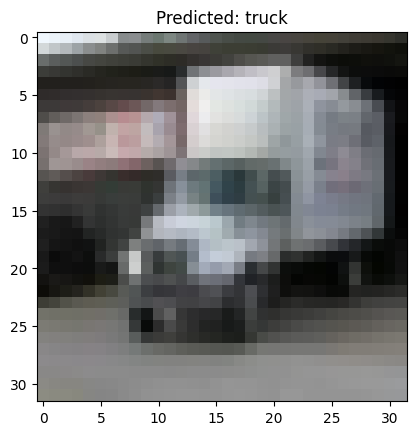

In [ ]:
n = get_watch(OneMoreConv, optim.RMSprop, lr = 0.00004, epoch=5, normalize=True, scheduler=True)
visualize_result(getnum(), n)

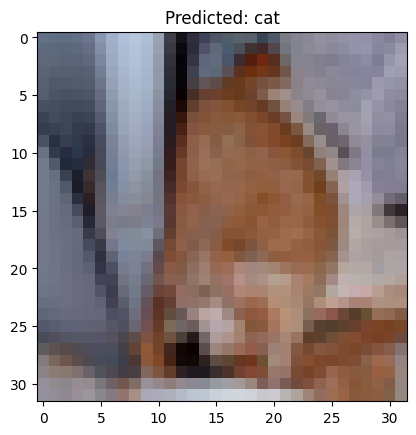

In [ ]:
visualize_result(getnum(), n)

In [20]:
class ConvoNet(nn.Module):
  def __init__(self):
    super(ConvoNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels = 16, kernel_size=3, padding = 1)
    self.act1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 2)

    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding=1)
    self.act2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(2, 2)

    self.conv3 = nn.Conv2d(in_channels=32, out_channels = 64, kernel_size=3, padding=1)
    self.act3 = nn.ReLU()

    self.fc1 = nn.Linear(8*8*64, 256)
    self.act4 = nn.ReLU()

    self.fc2 = nn.Linear(256, 64)
    self.act5 = nn.ReLU()

    self.fc3 = nn.Linear(64, 10)

    for layer in [self.conv1, self.conv2, self.conv3, self.fc1, self.fc2, self.fc3]:
      nn.init.kaiming_normal_(layer.weight)


  def forward(self, x):
    x = self.pool1(self.act1(self.conv1(x)))
    x = self.pool2(self.act2(self.conv2(x)))
    x = self.act3(self.conv3(x))

    x = x.view(x.size(0), -1)

    x = self.act4(self.fc1(x))
    x = self.act5(self.fc2(x))
    x = self.fc3(x)

    return x

In [29]:
tryout = get_watch(ConvoNet, epoch = 5)

<ipython-input-28-60b2302c765e>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 1, loss: 3.087
Epoch: 1, loss: 2359.59
Epoch: 1, loss: 1969.724
Epoch: 1, loss: 1874.677
Epoch: 1, loss: 1773.07
Epoch: 1, loss: 1674.531
Epoch: 1, loss: 1627.239
Epoch: 1, loss: 1575.832
Epoch: 1, loss: 1496.658
Epoch: 1, loss: 1546.632


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 2, loss: 0.389
Epoch: 2, loss: 1283.178
Epoch: 2, loss: 1291.029
Epoch: 2, loss: 1260.719
Epoch: 2, loss: 1280.578
Epoch: 2, loss: 1238.976
Epoch: 2, loss: 1277.961
Epoch: 2, loss: 1244.889
Epoch: 2, loss: 1232.125
Epoch: 2, loss: 1211.075


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 3, loss: 1.625
Epoch: 3, loss: 1032.728
Epoch: 3, loss: 1026.789
Epoch: 3, loss: 996.966
Epoch: 3, loss: 990.112
Epoch: 3, loss: 983.063
Epoch: 3, loss: 987.998
Epoch: 3, loss: 1017.864
Epoch: 3, loss: 991.793
Epoch: 3, loss: 983.638


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.721
Epoch: 4, loss: 752.262
Epoch: 4, loss: 781.02
Epoch: 4, loss: 784.741
Epoch: 4, loss: 766.162
Epoch: 4, loss: 804.785
Epoch: 4, loss: 802.367
Epoch: 4, loss: 798.41
Epoch: 4, loss: 814.429
Epoch: 4, loss: 787.088


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 5, loss: 0.893
Epoch: 5, loss: 553.9
Epoch: 5, loss: 591.652
Epoch: 5, loss: 592.254
Epoch: 5, loss: 609.444
Epoch: 5, loss: 624.638
Epoch: 5, loss: 609.335
Epoch: 5, loss: 595.478
Epoch: 5, loss: 644.394
Epoch: 5, loss: 601.075
Accuracy: plane: 80.9%
Accuracy: car: 75.1%
Accuracy: bird: 51.4%
Accuracy: cat: 50.7%
Accuracy: deer: 71.8%
Accuracy: dog: 50.5%
Accuracy: frog: 65.3%
Accuracy: horse: 80.3%
Accuracy: ship: 80.7%
Accuracy: truck: 73.3%


test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆▇█
train_loss,▅█▅▅▁
test_accuracy,0.68
test_loss,2490.29503
train_accuracy,0.83202
train_loss,0.04433


If we compare a simple architecture (3 convolution layers padding1 and two pooling + 3 fully connected layers with kaiming initialized weights for relu) to a more sophisticated (3 conv layers padding1 with filter3 with two 2x2 pooling and 2 filter1 padding0 conv layers all batch normalized and 3 fully-connected layers and a dropout before the last one) we can see that the difference is not that huge(about 1%). Surely it's waaaay better that any net used here with kernel size of 5 but for kernel 3 the difference in architecture is not that drastical. Moreover if we use kaiming initialization for weights on every layer, the accuracy on train epochs for these different architectures follows similar path with equal score.